[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/cyneuro/Neural-Networks-Machine-Learning/blob/master/Logistic-Regression/LogisticRegressionGradDescent.ipynb)

## Logistic Regression using Gradient Descent
#### By Gregory Glickert

### The first thing we need to do is get some data generated


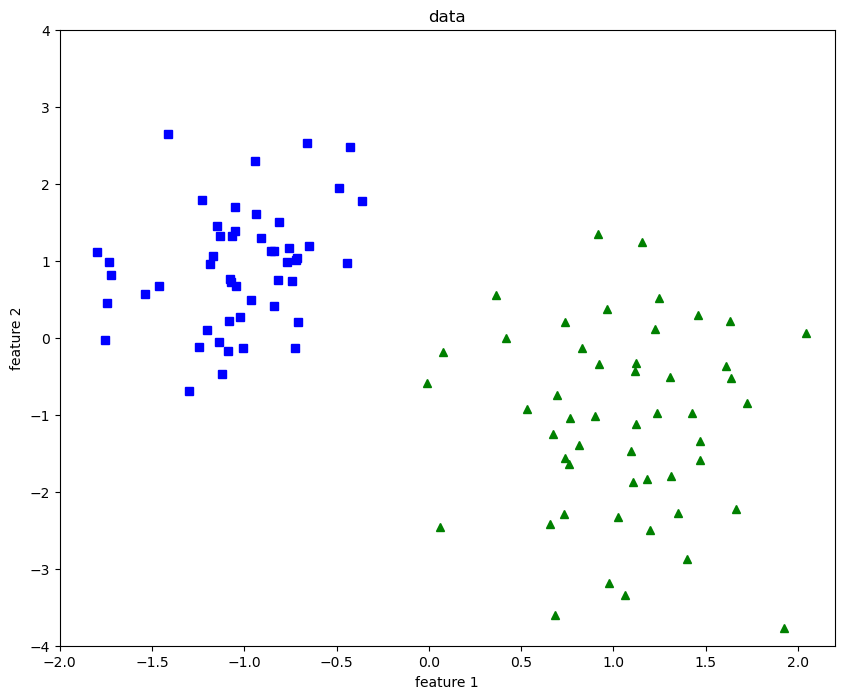

In [1]:
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

X, y = make_classification(n_features=2, n_redundant=0, 
                           n_informative=2, random_state=8, 
                           n_clusters_per_class=1)

fig = plt.figure(figsize=(10,8))
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "g^")
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs")
plt.xlabel("feature 1")
plt.ylabel("feature 2")
plt.title("data")
xmin, xmax = -2, 2.2
ymin, ymax = -4, 4
plt.ylim(ymin,ymax)
plt.xlim(xmin,xmax)
plt.show()


## Explanation of the `predict` Function

The `predict` function computes the predicted probability $\hat{y}$ for a given input $x$ and model parameters $w$ (weights) and $b$ (bias):

$$
\hat{y} = \frac{1}{1 + e^{-(w \cdot x + b)}}
$$


In [2]:
# Logistic function (sigmoid)
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# Predict function using the sigmoid function
def predict(X, w, b):
    z = np.dot(X, w) + b
    return sigmoid(z)


### Cross-Entropy Loss

The **cross-entropy loss** is used as the cost function for logistic regression:

$$
J(w, b) = - \frac{1}{n} \sum_{i=1}^{n} \left[ y_i \log(\hat{y}_i) + (1 - y_i) \log(1 - \hat{y}_i) \right]
$$

Where:
- $n$ is the number of data points,
- $y_i$ is the actual label for the \(i\)-th data point,
- $\hat{y}_i$ is the predicted probability for the \(i\)-th data point.



In [3]:
# Compute cross-entropy loss
def compute_cost(X, y, w, b):
    m = len(y)
    predictions = predict(X, w, b)
    cost = -1/m * np.sum(y * np.log(predictions) + (1 - y) * np.log(1 - predictions))
    return cost


In [4]:
def find_boundary(w,b):
    m = -w[0]/w[1]
    b = -b/w[1]
    xmin, xmax = -2, 2.2 #picked to make plot look nice
    ymin, ymax = -4, 4 # same here
    xd = np.array([xmin, xmax])
    # y=mx+b
    yd = m * xd + b
    
    return xd,yd    

### Gradient Descent

**Gradient Descent** is an iterative optimization algorithm used to minimize the cross-entropy loss function in logistic regression. The update rules for the parameters during each iteration are:

$$
w := w - \alpha \cdot \frac{1}{n} \sum_{i=1}^{n} (\hat{y}_i - y_i) \cdot x_i
$$

$$
b := b - \alpha \cdot \frac{1}{n} \sum_{i=1}^{n} (\hat{y}_i - y_i)
$$

Where:
- $\alpha$ is the learning rate,
- $n$ is the number of data points,
- $x_i$ and $y_i$ are the individual data points.


In [5]:
# Gradient descent function
def gradient_descent(X, y, w_init, b_init, learning_rate, n_iterations, show_progress=True):
    w = w_init
    b = b_init
    m = len(y)
    cost_history = []

    for iteration in range(n_iterations):
        # Log model prediction
        predictions = predict(X, w, b)
        
        # Gradients
        dw = (1/m) * np.dot(X.T, (predictions - y)) #two weights so easier to update with matrix form
        db = (1/m) * np.sum(predictions - y)
        
        # Update parameters
        w -= learning_rate * dw
        b -= learning_rate * db
        
        # Compute and store cost
        cost_history.append(compute_cost(X, y, w, b))
        
        # Show progress
        if show_progress and iteration % 25 == 0:
            print(f"Iteration {iteration}: Cost = {cost_history[-1]}")
            xd,yd = find_boundary(w=w,b=b)

            plt.figure(figsize=(10, 8))
            plt.plot(xd, yd, 'k', lw=1, ls='--')
            plt.fill_between(xd, yd, ymin, color='tab:blue', alpha=0.2,label='group1')
            plt.fill_between(xd, yd, ymax, color='tab:orange', alpha=0.2,label='group2')
            plt.plot(X[:, 0][y==0], X[:, 1][y==0], "g^")
            plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs")
            plt.xlabel("Feature 1")
            plt.ylabel("Feature 2")
            plt.title("Logistic Regression Decision Boundary")
            plt.xlim((-2,2))
            plt.ylim((-4,4))
            plt.legend()
            plt.show()
            
    
    return w, b, cost_history


Iteration 0: Cost = 0.6465339490082839


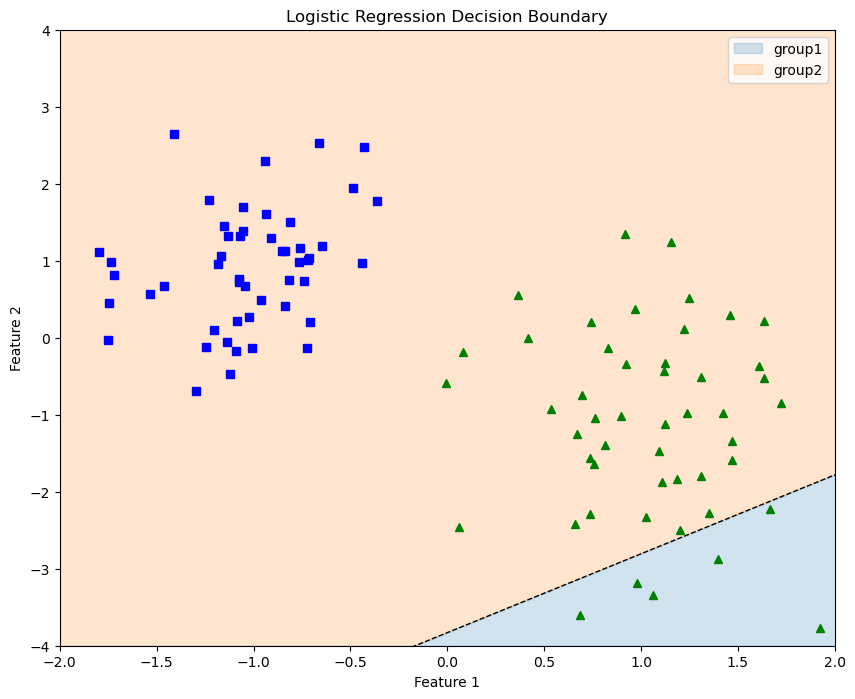

Iteration 25: Cost = 0.23966441156976628


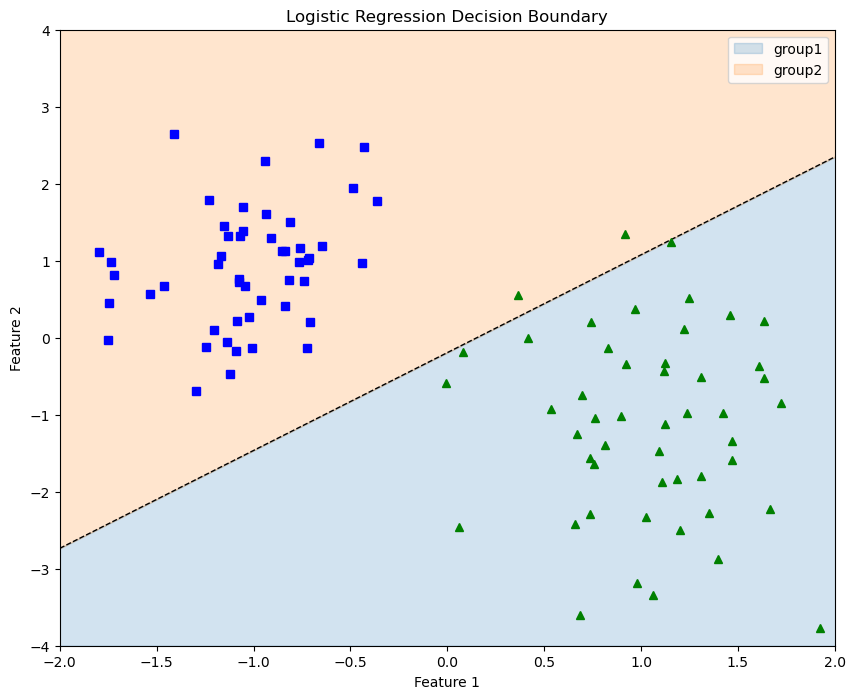

Iteration 50: Cost = 0.15986460549853224


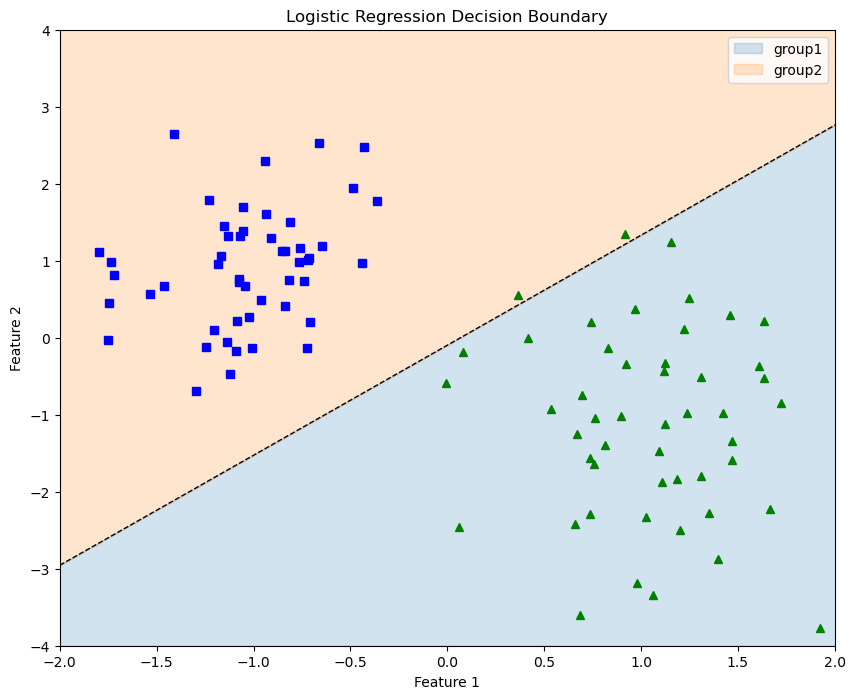

Iteration 75: Cost = 0.12397378358819883


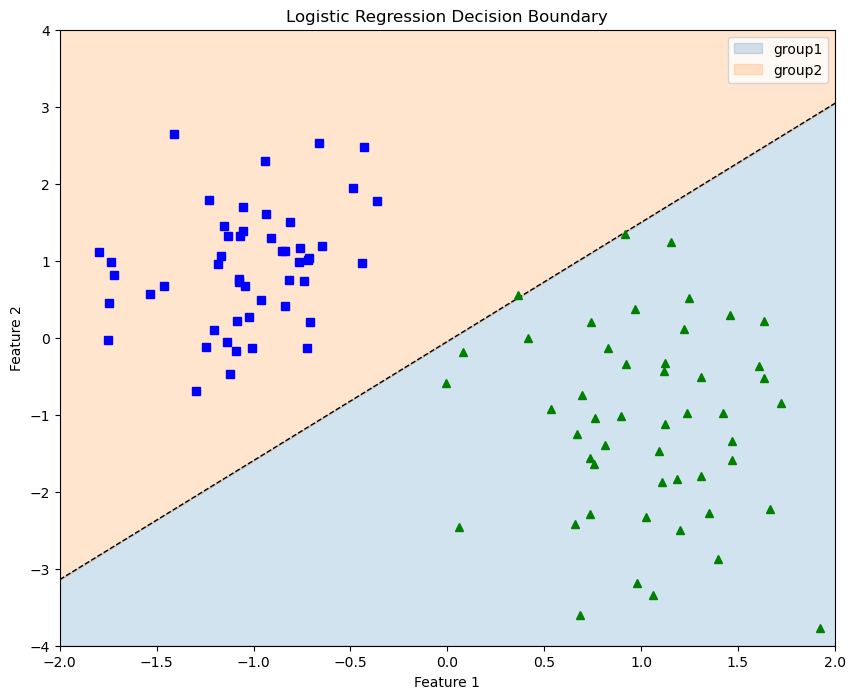

Iteration 100: Cost = 0.1029182661574105


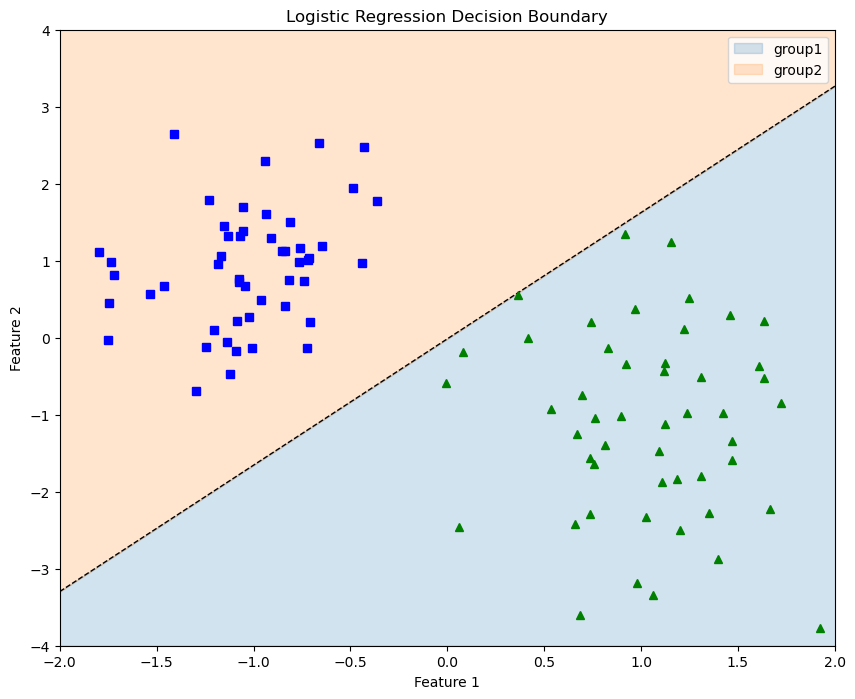

Iteration 125: Cost = 0.08883013053166693


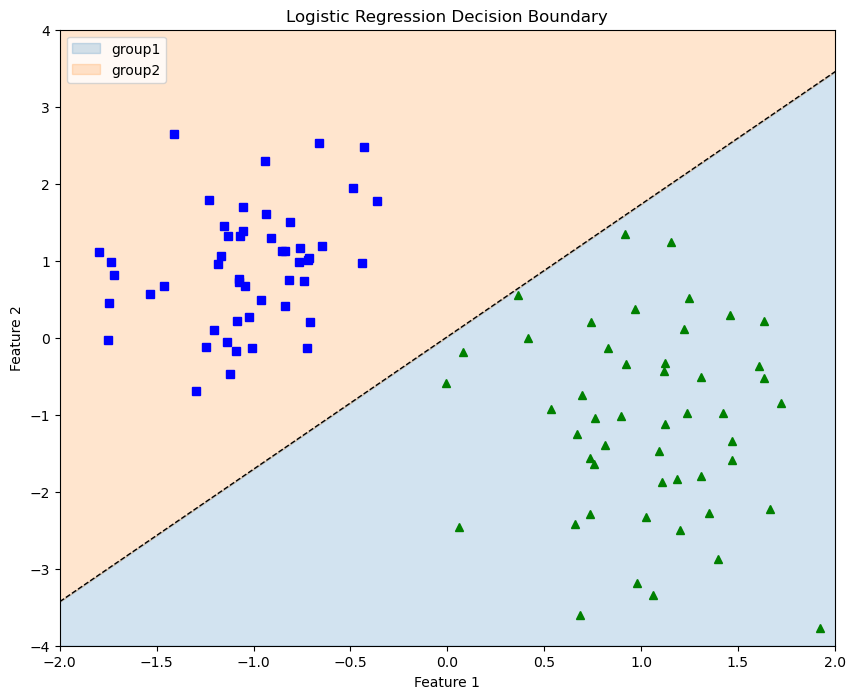

Iteration 150: Cost = 0.07863192381637091


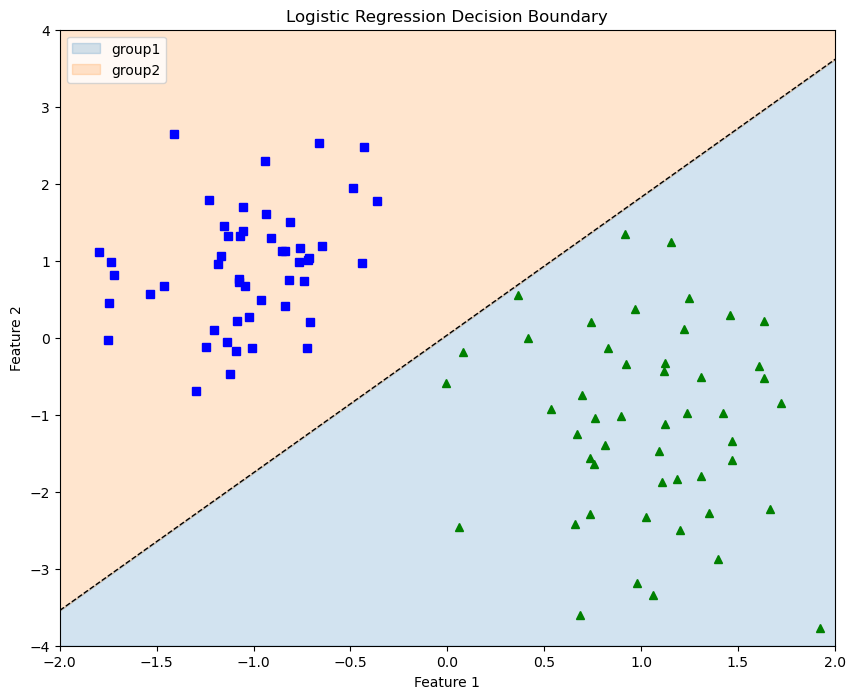

Iteration 175: Cost = 0.07085188198087043


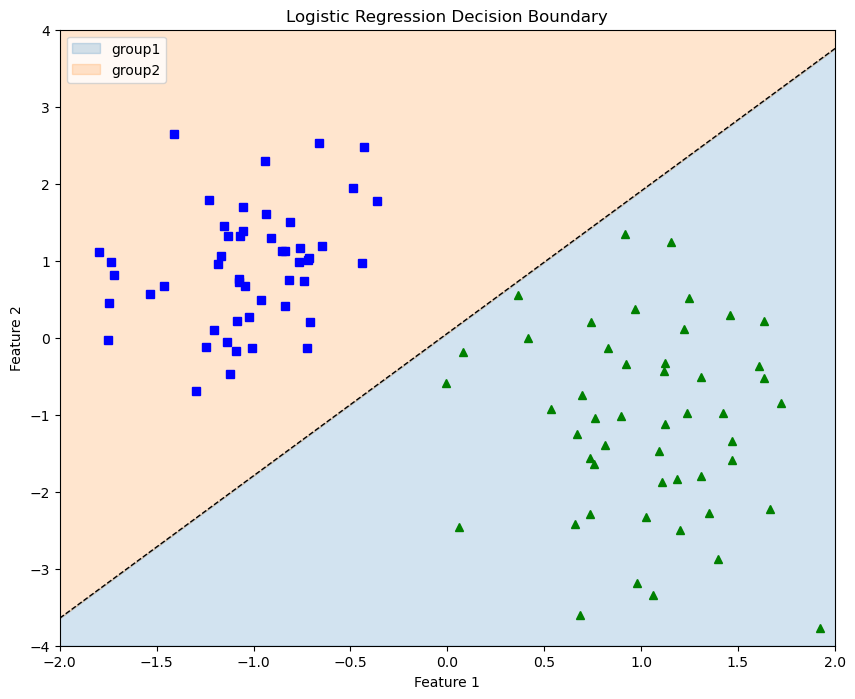

In [6]:
# Initialize parameters
w_init = np.zeros(X.shape[1])  # Initial weight vector
b_init = 0.2  # Initial bias term
learning_rate = 0.1
n_iterations = 200
show_progress = True  # Set to True if you want to see the progress during training

# Perform gradient descent to find the optimal weights and bias
optimal_w, optimal_b, cost_history = gradient_descent(X, y, w_init, b_init, learning_rate, n_iterations, show_progress)


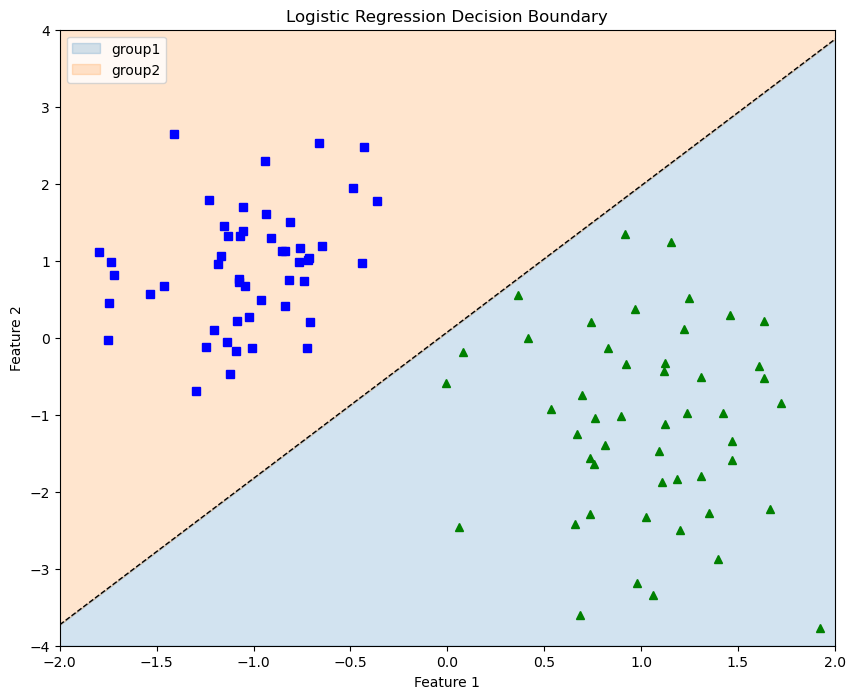

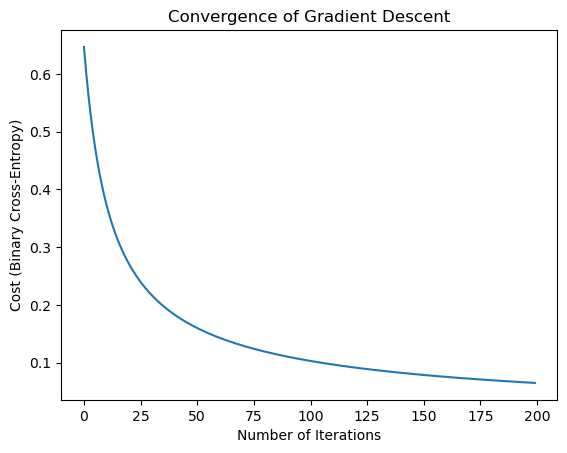

Final weights: [-2.27121    1.1951296]
Final bias: -0.0879809997133691


In [7]:
xd,yd = find_boundary(w=optimal_w,b=optimal_b)

plt.figure(figsize=(10, 8))
plt.plot(xd, yd, 'k', lw=1, ls='--')
plt.fill_between(xd, yd, ymin, color='tab:blue', alpha=0.2,label='group1')
plt.fill_between(xd, yd, ymax, color='tab:orange', alpha=0.2,label='group2')
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "g^")
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Logistic Regression Decision Boundary")
plt.xlim((-2,2))
plt.ylim((-4,4))
plt.legend()
plt.show()

# Plot the cost function's history
plt.plot(range(len(cost_history)), cost_history)
plt.xlabel('Number of Iterations')
plt.ylabel('Cost (Binary Cross-Entropy)')
plt.title('Convergence of Gradient Descent')
plt.show()

# Output final weights and bias
print(f"Final weights: {optimal_w}")
print(f"Final bias: {optimal_b}")